In [1]:
import utils.cs_vqe_tools as c_tools
import utils.qonversion_tools as qonvert
import utils.bit_tools as bit
import utils.circuit_tools as circ
import utils.linalg_tools as la
import cs_vqe_classes.cs_vqe as c
import cs_vqe_classes.eigenstate as eig
import cs_vqe_classes.cs_vqe_circuit as cs_circ

import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
from openfermion.linalg import LinearQubitOperator, get_sparse_operator, get_ground_state
import itertools
from statistics import median

from qiskit.circuit.parameter import Parameter
from qiskit.circuit.quantumcircuit import QuantumCircuit, QuantumRegister
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.aqua.components.optimizers import SLSQP, COBYLA
from qiskit.algorithms import VQE
from qiskit import Aer

from qiskit.providers.aer import AerError

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


In [2]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)

singlet_bool = True # Set general UCCSD or singlet UCCSD.

bond_len = 0.772#1.45
atom_1 = 'He'
atom_2 = 'H'
basis = '3-21g'
multiplicity = 1
charge = 1

coordinate_1 = (0.0, 0.0, 0.0)
coordinate_2 = (0.0, 0.0, bond_len)
geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2)]

molecule_data = MolecularData(geometry, basis, multiplicity, charge, description='Test')
#molecule.load()

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Run pyscf.
molecule = run_pyscf(molecule_data,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci)

#molecule.load()
#print(molecule)

ham_f = get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_q = jordan_wigner(ham_f)
print('Hamiltonian:', '\n', ham_q, '\n')

scf = True      # Hartree-Fock.
mp2 = True      # Moller-Plesset 2.
cisd = True     # Configuration interaction singles and doubles.
ccsd = True     # Coupled cluster singles and doubles.
fci = True      # Full configuration interaction.

calculated_molecule = run_pyscf(molecule_data, scf, mp2, cisd, ccsd, fci)

if ccsd:
    ccsd_single_amps = calculated_molecule.ccsd_single_amps
    ccsd_double_amps = calculated_molecule.ccsd_double_amps

num_electrons = calculated_molecule.n_electrons
num_qubits = 2*calculated_molecule.n_orbitals

if singlet_bool:
    # Get singlet UCCSD generator.
    packed_amps = uccsd_singlet_get_packed_amplitudes(ccsd_single_amps,  ccsd_double_amps, num_qubits, num_electrons)
    ucc_sing = uccsd_singlet_generator(packed_amps, num_qubits, num_electrons)
    #print(ucc_sing)

else:
    # Get general UCCSD operator.
    ucc_op = uccsd_generator(ccsd_single_amps, ccsd_double_amps)
    #print(ucc_op)
    
ucc_q = jordan_wigner(ucc_sing)
ucc = qonvert.QubitOperator_to_dict(ucc_q, num_qubits)
print('UCCSD ansatz:', '\n', ucc_q)

Hamiltonian: 
 (1.132443402106941+0j) [] +
(-0.025810254414815714+0j) [X0 X1 Y2 Y3] +
(-0.012799934786436745+0j) [X0 X1 Y2 Z3 Z4 Y5] +
(-0.025159645839898232+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Y7] +
(-0.012799934786436745+0j) [X0 X1 X3 X4] +
(-0.025159645839898232+0j) [X0 X1 X3 Z4 Z5 X6] +
(-0.017114528821774503+0j) [X0 X1 Y4 Y5] +
(-0.0009891049103622643+0j) [X0 X1 Y4 Z5 Z6 Y7] +
(-0.0009891049103622643+0j) [X0 X1 X5 X6] +
(-0.05469856574684905+0j) [X0 X1 Y6 Y7] +
(0.025810254414815714+0j) [X0 Y1 Y2 X3] +
(0.012799934786436745+0j) [X0 Y1 Y2 Z3 Z4 X5] +
(0.025159645839898232+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 X7] +
(-0.012799934786436745+0j) [X0 Y1 Y3 X4] +
(-0.025159645839898232+0j) [X0 Y1 Y3 Z4 Z5 X6] +
(0.017114528821774503+0j) [X0 Y1 Y4 X5] +
(0.0009891049103622643+0j) [X0 Y1 Y4 Z5 Z6 X7] +
(-0.0009891049103622643+0j) [X0 Y1 Y5 X6] +
(0.05469856574684905+0j) [X0 Y1 Y6 X7] +
(0.0025779051794142457+0j) [X0 Z1 X2] +
(0.0047661481056806764+0j) [X0 Z1 X2 X3 Z4 X5] +
(-0.00926470292330834+0j) [X0 Z1 X2 X3

UCCSD ansatz: 
 0.006478936130101663j [X0 X1 X2 Y3] +
0.006478936130101663j [X0 X1 Y2 X3] +
0.002056274402971786j [X0 X1 X4 Y5] +
0.002056274402971786j [X0 X1 Y4 X5] +
0.005083283191416566j [X0 X1 X6 Y7] +
0.005083283191416566j [X0 X1 Y6 X7] +
-0.006478936130101663j [X0 Y1 X2 X3] +
0.006478936130101663j [X0 Y1 Y2 Y3] +
-0.002056274402971786j [X0 Y1 X4 X5] +
0.002056274402971786j [X0 Y1 Y4 Y5] +
-0.005083283191416566j [X0 Y1 X6 X7] +
0.005083283191416566j [X0 Y1 Y6 Y7] +
-0.006360390047802359j [X0 Z1 Y2] +
-0.002645411873724388j [X0 Z1 Z2 Z3 Y4] +
0.0009221551709257067j [X0 Z1 Z2 Z3 Z4 Z5 Y6] +
-0.006478936130101663j [Y0 X1 X2 X3] +
0.006478936130101663j [Y0 X1 Y2 Y3] +
-0.002056274402971786j [Y0 X1 X4 X5] +
0.002056274402971786j [Y0 X1 Y4 Y5] +
-0.005083283191416566j [Y0 X1 X6 X7] +
0.005083283191416566j [Y0 X1 Y6 Y7] +
-0.006478936130101663j [Y0 Y1 X2 Y3] +
-0.006478936130101663j [Y0 Y1 Y2 X3] +
-0.002056274402971786j [Y0 Y1 X4 Y5] +
-0.002056274402971786j [Y0 Y1 Y4 X5] +
-0.005083283

In [3]:
f = open("hamiltonians/hamiltonians.txt","r")
hamiltonians = ast.literal_eval(f.read())
f.close()

hamiltonians.keys()

dict_keys(['H2-S1_STO-3G_singlet', 'C1-O1_STO-3G_singlet', 'H1-Cl1_STO-3G_singlet', 'H1-Na1_STO-3G_singlet', 'H2-Mg1_STO-3G_singlet', 'H1-F1_3-21G_singlet', 'H1-Li1_3-21G_singlet', 'Be1_STO-3G_singlet', 'H1-F1_STO-3G_singlet', 'H1-Li1_STO-3G_singlet', 'Ar1_STO-3G_singlet', 'F2_STO-3G_singlet', 'H1-O1_STO-3G_singlet', 'H2-Be1_STO-3G_singlet', 'H2-O1_STO-3G_singlet', 'H2_3-21G_singlet', 'H2_6-31G_singlet', 'H3-N1_STO-3G_singlet', 'H4-C1_STO-3G_singlet', 'Mg1_STO-3G_singlet', 'N2_STO-3G_singlet', 'Ne1_STO-3G_singlet', 'O2_STO-3G_singlet', 'H1-Li1-O1_STO-3G_singlet', 'H1-He1_STO-3G_singlet', 'H3_STO-3G_singlet_1+', 'H1-He1_3-21G_singlet_1+', 'H3_3-21G_singlet_1+', 'H4-N1_STO-3G_singlet_1+'])

In [4]:
#speciesname = 'Ne1_STO-3G_singlet'

#num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
#hamiltonian = hamiltonians[speciesname][2] # full Hamiltonian
#terms_noncon = list(hamiltonians[speciesname][3].keys()) # noncontextual part of Hamiltonian, found by greedy DFS
hamiltonian = qonvert.QubitOperator_to_dict(ham_q, num_qubits)#
terms_noncon = c_tools.greedy_dfs(hamiltonian, 1, criterion='weight')[-1]
mol = c.cs_vqe(hamiltonian, terms_noncon, num_qubits)

In [5]:
ham = mol.get_ham(h_type='full', rot=True)
ham_noncon = mol.get_ham(h_type='noncon', rot=True)
ham_context = mol.get_ham(h_type='context', rot=True)

ham_q = qonvert.dict_to_QubitOperator(ham)
ham_noncon_q = qonvert.dict_to_QubitOperator(ham_noncon)
ham_context_q = qonvert.dict_to_QubitOperator(ham_context)

generators = mol.generators(rot=True)
G = generators[0]
A = generators[1]

In [6]:
print('commuting generators:',G, '\n')
print('anticommuting generators:',A, '\n')
#print('Minimising configuration:', gs_noncon[1])

commuting generators: {'ZIIIIIII': 1.0, 'IZIIIIII': 1.0, 'IIZIIIII': 1.0, 'IIIZIIII': -1.0, 'IIIIZIII': 1.0, 'IIIIIZII': 1.0, 'IIIIIIIZ': 1.0} 

anticommuting generators: {'IZZZZZXI': 0.04017216409926001, 'IIIIIIZI': 0.9991927728079213} 



In [7]:
mol.reduced_hamiltonian(order=[6, 0, 1, 2, 3, 4, 5, 7])

Initial order [6, 0, 0, 0, 0, 0, 0, 0]
Z_indices: [0, 1, 2, 3, 4, 5, 7] ['ZIIIIIII', 'IZIIIIII', 'IIZIIIII', 'IIIZIIII', 'IIIIZIII', 'IIIIIZII', 'IIIIIIIZ']
6
IIIIIIII I
6
ZIIIIIZI Z
6
IZZZZZXZ X
6
ZZZZZZXZ X
6
IZIIIIIZ I
6
IIZIIIII I
6
IIIZIIII I
6
IIIIZIII I
6
IIIIIZII I
6
IIIIIIZI Z
6
IIIIIIIZ I
6
ZZIIIIZZ Z
6
IIZZZZXI X
6
ZIZZZZXI X
6
ZIZIIIZI Z
6
IZIZZZXZ X
6
ZZIZZZXZ X
6
ZIIZIIZI Z
6
IZZIZZXZ X
6
ZZZIZZXZ X
6
ZIIIZIZI Z
6
IZZZIZXZ X
6
ZZZZIZXZ X
6
ZIIIIZZI Z
6
IZZZZIXZ X
6
ZZZZZIXZ X
6
ZIIIIIII I
6
ZIIIIIZZ Z
6
IZZZZZXI X
6
ZZZZZZXI X
6
IZZIIIIZ I
6
IZIZIIIZ I
6
IZIIZIIZ I
6
IZIIIZIZ I
6
IZIIIIZZ Z
6
IZIIIIII I
6
IIZZIIII I
6
IIZIZIII I
6
IIZIIZII I
6
IIZIIIZI Z
6
IIZIIIIZ I
6
IIIZZIII I
6
IIIZIZII I
6
IIIZIIZI Z
6
IIIZIIIZ I
6
IIIIZZII I
6
IIIIZIZI Z
6
IIIIZIIZ I
6
IIIIIZZI Z
6
IIIIIZIZ I
6
IIIIIIZZ Z
order after [6, 0, 0, 0, 0, 0, 0, 0]
Z_indices: [0, 1, 2, 3, 4, 5] ['ZIIIIIII', 'IZIIIIII', 'IIZIIIII', 'IIIZIIII', 'IIIIZIII', 'IIIIIZII']
6
7
IIIIIIII II
6
7
ZIIIIIZI ZI
6
7
IZZZ

1
2
3
6
7
XXXYZZIY XXXYIY
0
1
2
3
6
7
XXXXZZIX XXXXIX
0
1
2
3
6
7
IXZXIIYY IXZXYY
0
1
2
3
6
7
IXZYIIYX IXZYYX
0
1
2
3
6
7
ZXZXIIYY ZXZXYY
0
1
2
3
6
7
ZXZYIIYX ZXZYYX
0
1
2
3
6
7
ZIIIZIZI ZIIIZI
0
1
2
3
6
7
YZYIZIIZ YZYIIZ
0
1
2
3
6
7
XZXIZIZZ XZXIZZ
0
1
2
3
6
7
IZZZIZXZ IZZZXZ
0
1
2
3
6
7
ZZZZIZXZ ZZZZXZ
0
1
2
3
6
7
ZIIIIZZI ZIIIZI
0
1
2
3
6
7
YZYIIZIZ YZYIIZ
0
1
2
3
6
7
XZXIIZZZ XZXIZZ
0
1
2
3
6
7
IZZZZIXZ IZZZXZ
0
1
2
3
6
7
ZZZZZIXZ ZZZZXZ
0
1
2
3
6
7
ZIIIIIII ZIIIII
0
1
2
3
6
7
YZYIIIZZ YZYIZZ
0
1
2
3
6
7
XZXIIIIZ XZXIIZ
0
1
2
3
6
7
ZIIIIIZZ ZIIIZZ
0
1
2
3
6
7
YZYIIIII YZYIII
0
1
2
3
6
7
XZXIIIZI XZXIZI
0
1
2
3
6
7
IZZZZZXI IZZZXI
0
1
2
3
6
7
ZZZZZZXI ZZZZXI
0
1
2
3
6
7
IZZIIIIZ IZZIIZ
0
1
2
3
6
7
IYIYIIII IYIYII
0
1
2
3
6
7
IXIXIIIZ IXIXIZ
0
1
2
3
6
7
IIIZZZZX IIIZZX
0
1
2
3
6
7
IZIZZZZX IZIZZX
0
1
2
3
6
7
YZYZZZXZ YZYZXZ
0
1
2
3
6
7
YZXZZZYZ YZXZYZ
0
1
2
3
6
7
YYXXZZXI YYXXXI
0
1
2
3
6
7
YYYXZZYI YYYXYI
0
1
2
3
6
7
YXXYZZXZ YXXYXZ
0
1
2
3
6
7
YXYYZZYZ YXYYYZ
0
1
2
3
6
7
YIXIIIYX Y

YIZIXZYI YIZIXYI
0
1
2
3
4
6
7
YIYZIZXI YIYZIXI
0
1
2
3
4
6
7
YIXZIZYI YIXZIYI
0
1
2
3
4
6
7
IIZIIZII IIZIIII
0
1
2
3
4
6
7
IIYZYZII IIYZYII
0
1
2
3
4
6
7
IIXZXZII IIXZXII
0
1
2
3
4
6
7
YIYZZIXI YIYZZXI
0
1
2
3
4
6
7
YIXZZIYI YIXZZYI
0
1
2
3
4
6
7
IIZIIIZI IIZIIZI
0
1
2
3
4
6
7
IIYZYIZI IIYZYZI
0
1
2
3
4
6
7
IIXZXIZI IIXZXZI
0
1
2
3
4
6
7
IIZIIIIZ IIZIIIZ
0
1
2
3
4
6
7
IIYZYIIZ IIYZYIZ
0
1
2
3
4
6
7
IIXZXIIZ IIXZXIZ
0
1
2
3
4
6
7
YIYZZZXZ YIYZZXZ
0
1
2
3
4
6
7
YIXZZZYZ YIXZZYZ
0
1
2
3
4
6
7
IIIZZIII IIIZZII
0
1
2
3
4
6
7
IYIYIZZX IYIYIZX
0
1
2
3
4
6
7
IYIXIZZY IYIXIZY
0
1
2
3
4
6
7
YIIZYZXI YIIZYXI
0
1
2
3
4
6
7
YIIZXZYI YIIZXYI
0
1
2
3
4
6
7
YYIYXIYX YYIYXYX
0
1
2
3
4
6
7
YYIYYIXX YYIYYXX
0
1
2
3
4
6
7
YYIXXIYY YYIXXYY
0
1
2
3
4
6
7
YYIXYIXY YYIXYXY
0
1
2
3
4
6
7
IIIZIZII IIIZIII
0
1
2
3
4
6
7
IYIYZIZX IYIYZZX
0
1
2
3
4
6
7
IYIXZIZY IYIXZZY
0
1
2
3
4
6
7
IIIZIIZI IIIZIZI
0
1
2
3
4
6
7
IYIYZZIX IYIYZIX
0
1
2
3
4
6
7
IYIXZZIY IYIXZIY
0
1
2
3
4
6
7
IIIZIIIZ IIIZIIZ
0
1
2
3
4
6
7
IIIIZZII

3
4
5
6
7
YYYZZYYY YYYZZYYY
0
1
2
3
4
5
6
7
YYXZZXXX YYXZZXXX
0
1
2
3
4
5
6
7
YYXZZYXY YYXZZYXY
0
1
2
3
4
5
6
7
IIZIIIZI IIZIIIZI
0
1
2
3
4
5
6
7
IIYZYIZI IIYZYIZI
0
1
2
3
4
5
6
7
IIXZXIZI IIXZXIZI
0
1
2
3
4
5
6
7
IIZIIIIZ IIZIIIIZ
0
1
2
3
4
5
6
7
IIYZYIIZ IIYZYIIZ
0
1
2
3
4
5
6
7
IIXZXIIZ IIXZXIIZ
0
1
2
3
4
5
6
7
YIYZZZXZ YIYZZZXZ
0
1
2
3
4
5
6
7
YIXZZZYZ YIXZZZYZ
0
1
2
3
4
5
6
7
IIIZZIII IIIZZIII
0
1
2
3
4
5
6
7
IIIYIYII IIIYIYII
0
1
2
3
4
5
6
7
IIIXIXII IIIXIXII
0
1
2
3
4
5
6
7
IYIYIZZX IYIYIZZX
0
1
2
3
4
5
6
7
IYIXIZZY IYIXIZZY
0
1
2
3
4
5
6
7
YIIZYZXI YIIZYZXI
0
1
2
3
4
5
6
7
YIIZXZYI YIIZXZYI
0
1
2
3
4
5
6
7
YIIYXXXI YIIYXXXI
0
1
2
3
4
5
6
7
YIIYYXYI YIIYYXYI
0
1
2
3
4
5
6
7
YIIXXYXI YIIXXYXI
0
1
2
3
4
5
6
7
YIIXYYYI YIIXYYYI
0
1
2
3
4
5
6
7
YYIYXIYX YYIYXIYX
0
1
2
3
4
5
6
7
YYIYYIXX YYIYYIXX
0
1
2
3
4
5
6
7
YYIXXIYY YYIXXIYY
0
1
2
3
4
5
6
7
YYIXYIXY YYIXYIXY
0
1
2
3
4
5
6
7
IIIZIZII IIIZIZII
0
1
2
3
4
5
6
7
IYIZIYZX IYIZIYZX
0
1
2
3
4
5
6
7
IYIZIXZY IYIZIXZY
0
1
2
3
4
5
6
7
IYIY

7
YZZZYIXX YZZZYIXX
0
1
2
3
4
5
6
7
IZIIIZIZ IZIIIZIZ
0
1
2
3
4
5
6
7
IXIIIYZY IXIIIYZY
0
1
2
3
4
5
6
7
IXIIIXZX IXIIIXZX
0
1
2
3
4
5
6
7
IYZYIZII IYZYIZII
0
1
2
3
4
5
6
7
IXZXIZIZ IXZXIZIZ
0
1
2
3
4
5
6
7
IIZZZIZX IIZZZIZX
0
1
2
3
4
5
6
7
IZZZZIZX IZZZZIZX
0
1
2
3
4
5
6
7
IZIIIIZZ IZIIIIZZ
0
1
2
3
4
5
6
7
IYZYIIZI IYZYIIZI
0
1
2
3
4
5
6
7
IXZXIIZZ IXZXIIZZ
0
1
2
3
4
5
6
7
IYZZZYZI IYZZZYZI
0
1
2
3
4
5
6
7
IXZZZXZZ IXZZZXZZ
0
1
2
3
4
5
6
7
IIZZZZIX IIZZZZIX
0
1
2
3
4
5
6
7
IZZZZZIX IZZZZZIX
0
1
2
3
4
5
6
7
IZIIIIII IZIIIIII
0
1
2
3
4
5
6
7
IYZYIIIZ IYZYIIIZ
0
1
2
3
4
5
6
7
IXZXIIII IXZXIIII
0
1
2
3
4
5
6
7
IYZZZYIZ IYZZZYIZ
0
1
2
3
4
5
6
7
IXZZZXII IXZZZXII
0
1
2
3
4
5
6
7
IIZZIIII IIZZIIII
0
1
2
3
4
5
6
7
IIYIYIII IIYIYIII
0
1
2
3
4
5
6
7
IIXIXIII IIXIXIII
0
1
2
3
4
5
6
7
YIYIZZXI YIYIZZXI
0
1
2
3
4
5
6
7
YIXIZZYI YIXIZZYI
0
1
2
3
4
5
6
7
IIZYZYII IIZYZYII
0
1
2
3
4
5
6
7
IIZXZXII IIZXZXII
0
1
2
3
4
5
6
7
IIYXXYII IIYXXYII
0
1
2
3
4
5
6
7
IIYYXXII IIYYXXII
0
1
2
3
4
5
6
7
IIXXYYII IIX

[{'I': (-1.8573610695628342+0j),
  'Z': (-1.284426018466561+0j),
  'X': (0.05163985793679032+0j)},
 {'II': (-0.5321905202811869+0j),
  'ZI': (-1.30406598505881+0j),
  'XZ': (0.061242445177349614+0j),
  'IZ': (-1.3251705492816477+0j),
  'ZX': (-0.02418363348411627+0j),
  'ZZ': (0.01963996659224887+0j),
  'XI': (-0.009602587240559235+0j),
  'IX': (0.009602587240559235+0j),
  'YY': (-0.2187942629873962+0j)},
 {'III': (-0.3557685706914644+0j),
  'ZZI': (-0.3832638100044006+0j),
  'IXZ': (0.03062122258867481+0j),
  'ZXZ': (0.03062122258867481+0j),
  'IIZ': (-1.3251705492816477+0j),
  'IZX': (-0.02418363348411627+0j),
  'IZI': (-0.9208021750544098+0j),
  'ZZZ': (0.01879787260033558+0j),
  'IXI': (-0.0048012936202796175+0j),
  'ZXI': (-0.0048012936202796175+0j),
  'ZIX': (-0.13168482247258806+0j),
  'IYY': (-0.1093971314936981+0j),
  'ZYY': (-0.1093971314936981+0j),
  'ZII': (-0.1764219495897224+0j),
  'IZZ': (0.0008420939919132897+0j),
  'IIX': (0.1412874097131473-0j)},
 {'IIII': (-0.1793466

In [8]:
initial_state=mol.init_state(rot=True)
index = bit.bin_to_int(initial_state)
print('Reference state index:', index, initial_state)
gs_noncon_energy = mol.gs_noncon_energy()
#take expectation value algebraically
psi = eig.eigenstate(A, index, num_qubits).construct()
#psi = eig.rotate_state(rotations, psi, num_qubits)
expect = la.expectation(ham_q, psi, num_qubits)

print('<H> w.r.t. simultaneous eigenstate:', expect)
print('Noncontextual approximation:', gs_noncon_energy)
print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match?

Reference state index: 16 00010000
<H> w.r.t. simultaneous eigenstate: (-3.142824749268175+0j)
Noncontextual approximation: -3.1428247492681765
Expectation values match? True


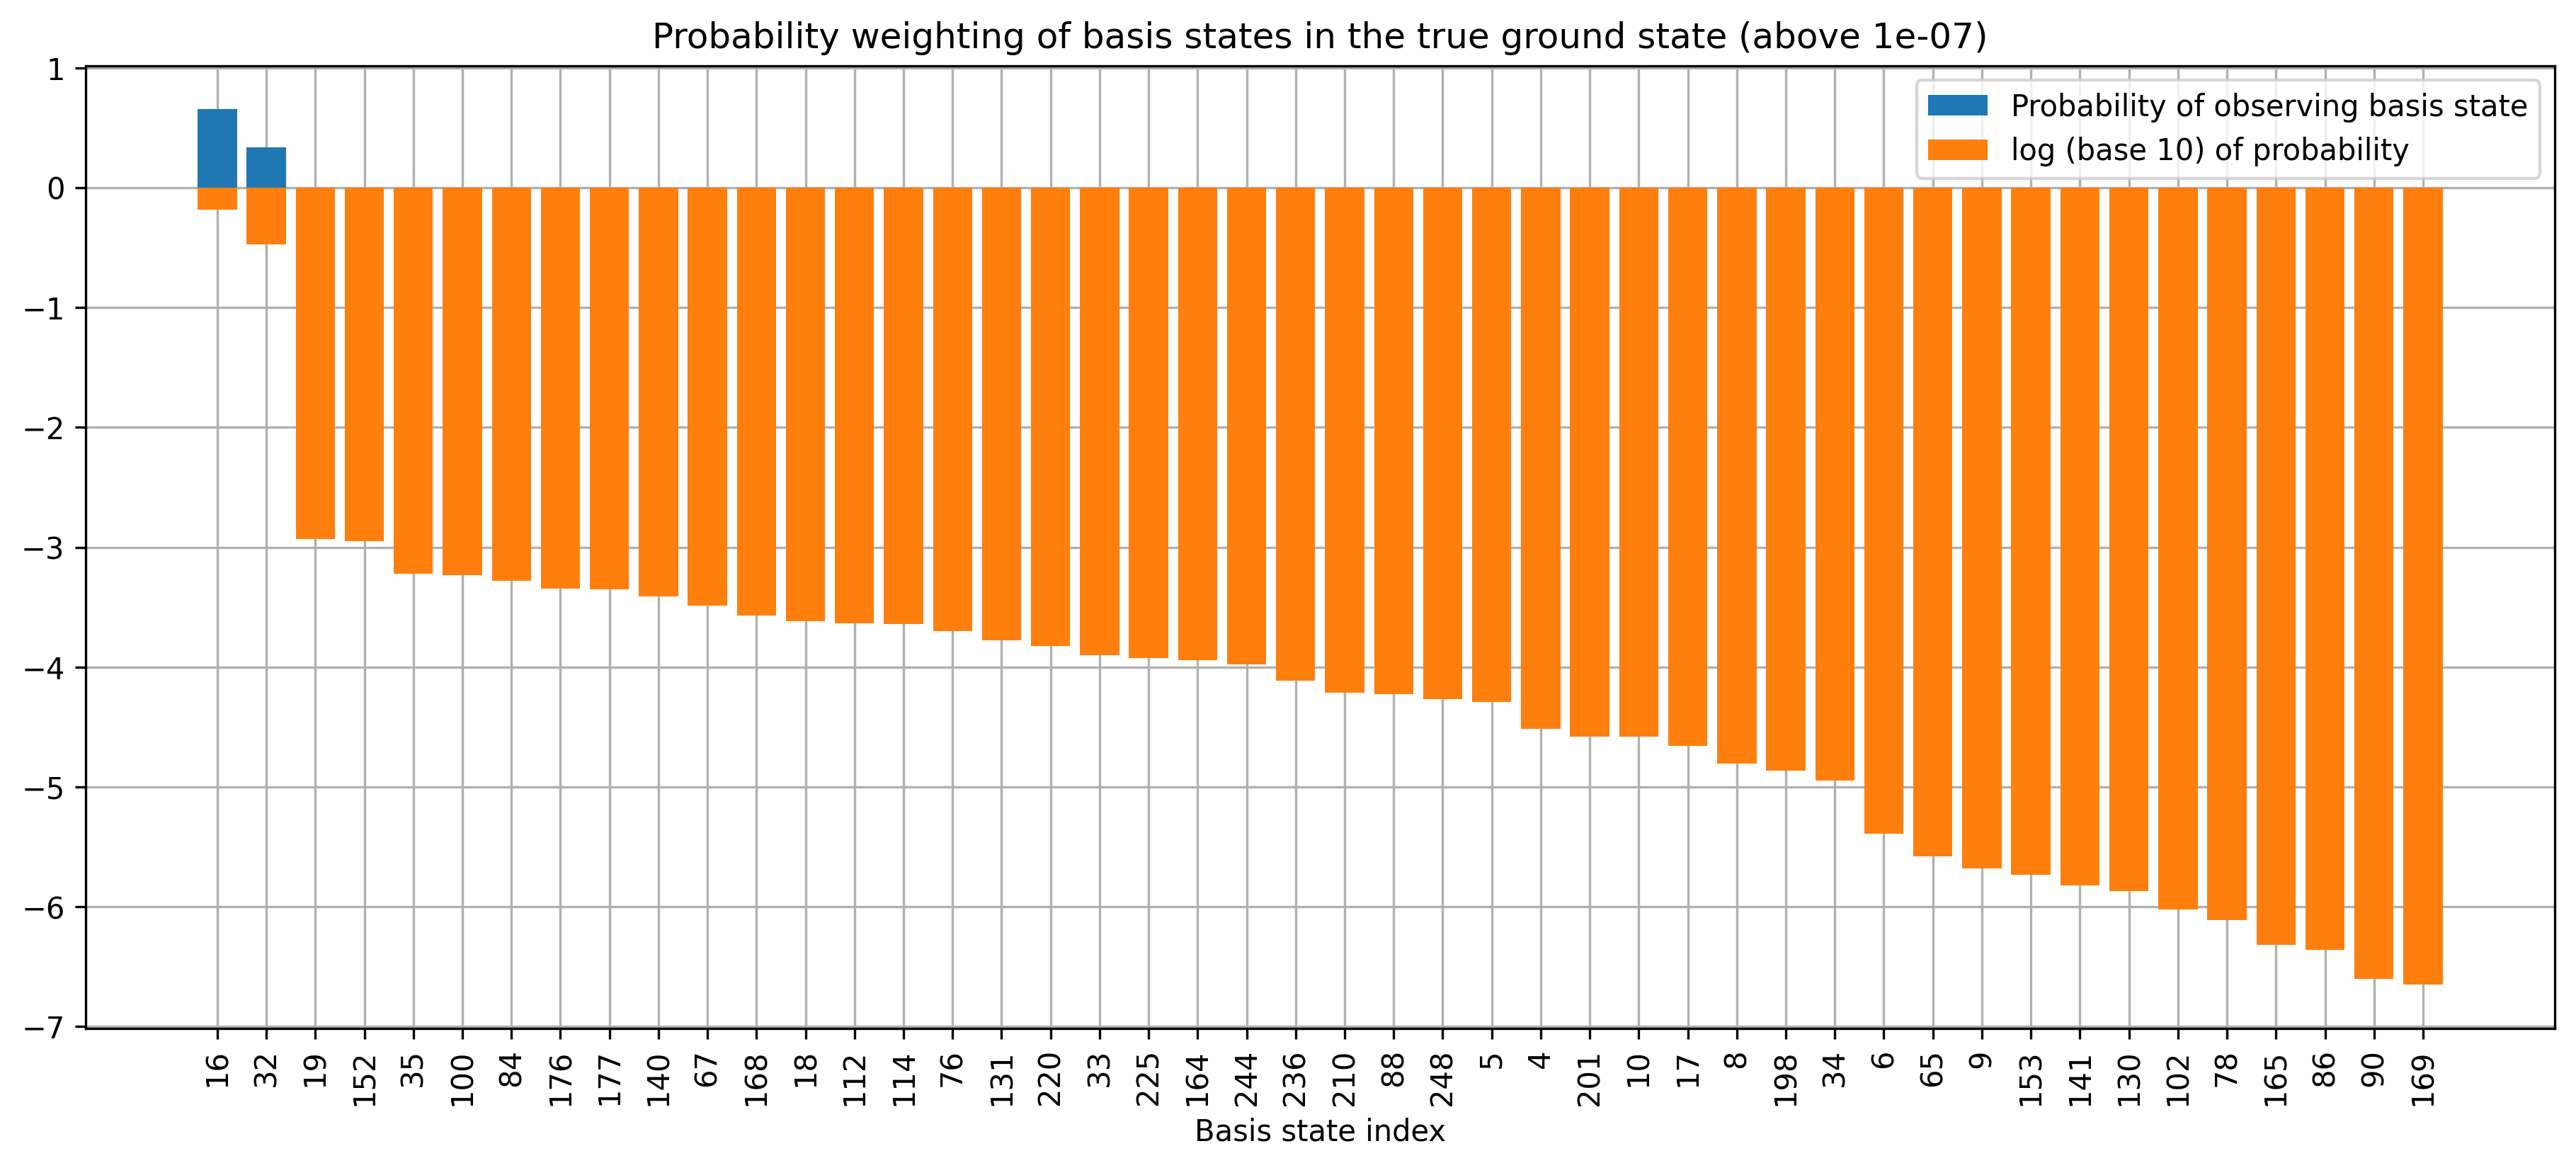

In [9]:
gs_hist = mol.true_gs_hist(threshold=1e-7, rot=True)

Initial order [6, 0, 0, 0, 0, 0, 0, 0]
Z_indices: [0, 1, 2, 3, 4, 5, 7] ['ZIIIIIII', 'IZIIIIII', 'IIZIIIII', 'IIIZIIII', 'IIIIZIII', 'IIIIIZII', 'IIIIIIIZ']
6
IIIIIIII I
6
ZIIIIIZI Z
6
IZZZZZXZ X
6
ZZZZZZXZ X
6
IZIIIIIZ I
6
IIZIIIII I
6
IIIZIIII I
6
IIIIZIII I
6
IIIIIZII I
6
IIIIIIZI Z
6
IIIIIIIZ I
6
ZZIIIIZZ Z
6
IIZZZZXI X
6
ZIZZZZXI X
6
ZIZIIIZI Z
6
IZIZZZXZ X
6
ZZIZZZXZ X
6
ZIIZIIZI Z
6
IZZIZZXZ X
6
ZZZIZZXZ X
6
ZIIIZIZI Z
6
IZZZIZXZ X
6
ZZZZIZXZ X
6
ZIIIIZZI Z
6
IZZZZIXZ X
6
ZZZZZIXZ X
6
ZIIIIIII I
6
ZIIIIIZZ Z
6
IZZZZZXI X
6
ZZZZZZXI X
6
IZZIIIIZ I
6
IZIZIIIZ I
6
IZIIZIIZ I
6
IZIIIZIZ I
6
IZIIIIZZ Z
6
IZIIIIII I
6
IIZZIIII I
6
IIZIZIII I
6
IIZIIZII I
6
IIZIIIZI Z
6
IIZIIIIZ I
6
IIIZZIII I
6
IIIZIZII I
6
IIIZIIZI Z
6
IIIZIIIZ I
6
IIIIZZII I
6
IIIIZIZI Z
6
IIIIZIIZ I
6
IIIIIZZI Z
6
IIIIIZIZ I
6
IIIIIIZZ Z
order after [6, 0, 0, 0, 0, 0, 0, 0]
Z_indices: [0, 1, 2, 3, 4, 5] ['ZIIIIIII', 'IZIIIIII', 'IIZIIIII', 'IIIZIIII', 'IIIIZIII', 'IIIIIZII']
6
7
IIIIIIII II
6
7
ZIIIIIZI ZI
6
7
IZZZ

IIIZIZII IIIZII
0
1
2
3
6
7
IYIYZIZX IYIYZX
0
1
2
3
6
7
IYIXZIZY IYIXZY
0
1
2
3
6
7
IIIZIIZI IIIZZI
0
1
2
3
6
7
IYIYZZIX IYIYIX
0
1
2
3
6
7
IYIXZZIY IYIXIY
0
1
2
3
6
7
IIIZIIIZ IIIZIZ
0
1
2
3
6
7
IIIIZZII IIIIII
0
1
2
3
6
7
IIIIZIZI IIIIZI
0
1
2
3
6
7
IIIIZIIZ IIIIIZ
0
1
2
3
6
7
IIIIIZZI IIIIZI
0
1
2
3
6
7
IIIIIZIZ IIIIIZ
0
1
2
3
6
7
IIIIIIZZ IIIIZZ
order after [0, 0, 0]
Z_indices: [5] ['IIIIIZII']
0
1
2
3
4
6
7
IIIIIIII IIIIIII
0
1
2
3
4
6
7
ZIIIIIZI ZIIIIZI
0
1
2
3
4
6
7
YZYIIIIZ YZYIIIZ
0
1
2
3
4
6
7
XZXIIIZZ XZXIIZZ
0
1
2
3
4
6
7
YZZZYIIZ YZZZYIZ
0
1
2
3
4
6
7
XZZZXIZZ XZZZXZZ
0
1
2
3
4
6
7
IZZZZZXZ IZZZZXZ
0
1
2
3
4
6
7
ZZZZZZXZ ZZZZZXZ
0
1
2
3
4
6
7
IZIIIIIZ IZIIIIZ
0
1
2
3
4
6
7
IYZYIIII IYZYIII
0
1
2
3
4
6
7
IXZXIIIZ IXZXIIZ
0
1
2
3
4
6
7
IIZZZZZX IIZZZZX
0
1
2
3
4
6
7
IZZZZZZX IZZZZZX
0
1
2
3
4
6
7
IIZIIIII IIZIIII
0
1
2
3
4
6
7
IIYZYIII IIYZYII
0
1
2
3
4
6
7
IIXZXIII IIXZXII
0
1
2
3
4
6
7
YIYZZZXI YIYZZXI
0
1
2
3
4
6
7
YIXZZZYI YIXZZYI
0
1
2
3
4
6
7
IIIZIIII IIIZIII
0
1
2
3
4

3
4
5
6
7
ZIZZZZXI ZIZZZZXI
0
1
2
3
4
5
6
7
ZYZYIIZI ZYZYIIZI
0
1
2
3
4
5
6
7
ZXZXIIZZ ZXZXIIZZ
0
1
2
3
4
5
6
7
YXXYIIIZ YXXYIIIZ
0
1
2
3
4
5
6
7
YYXXIIII YYXXIIII
0
1
2
3
4
5
6
7
XXYYIIZZ XXYYIIZZ
0
1
2
3
4
5
6
7
XYYXIIZI XYYXIIZI
0
1
2
3
4
5
6
7
YXIXYIIZ YXIXYIIZ
0
1
2
3
4
5
6
7
YYIYYIII YYIYYIII
0
1
2
3
4
5
6
7
XXIXXIZZ XXIXXIZZ
0
1
2
3
4
5
6
7
XYIYXIZI XYIYXIZI
0
1
2
3
4
5
6
7
IXIXZZXZ IXIXZZXZ
0
1
2
3
4
5
6
7
IYIYZZXI IYIYZZXI
0
1
2
3
4
5
6
7
ZXIXZZXZ ZXIXZZXZ
0
1
2
3
4
5
6
7
ZYIYZZXI ZYIYZZXI
0
1
2
3
4
5
6
7
ZYZZZYZI ZYZZZYZI
0
1
2
3
4
5
6
7
ZXZZZXZZ ZXZZZXZZ
0
1
2
3
4
5
6
7
YXXZZYIZ YXXZZYIZ
0
1
2
3
4
5
6
7
YYXZZXII YYXZZXII
0
1
2
3
4
5
6
7
XXYZZYZZ XXYZZYZZ
0
1
2
3
4
5
6
7
XYYZZXZI XYYZZXZI
0
1
2
3
4
5
6
7
YXIIXYIZ YXIIXYIZ
0
1
2
3
4
5
6
7
YYIIXXII YYIIXXII
0
1
2
3
4
5
6
7
XXIIYYZZ XXIIYYZZ
0
1
2
3
4
5
6
7
XYIIYXZI XYIIYXZI
0
1
2
3
4
5
6
7
IXIIIXXZ IXIIIXXZ
0
1
2
3
4
5
6
7
IYIIIYXI IYIIIYXI
0
1
2
3
4
5
6
7
ZXIIIXXZ ZXIIIXXZ
0
1
2
3
4
5
6
7
ZYIIIYXI ZYIIIYXI
0
1
2
3
4
5
6
7
ZIZZ

2
3
4
5
6
7
YIZIXZYI YIZIXZYI
0
1
2
3
4
5
6
7
YIYZIZXI YIYZIZXI
0
1
2
3
4
5
6
7
YIXZIZYI YIXZIZYI
0
1
2
3
4
5
6
7
IIZIIZII IIZIIZII
0
1
2
3
4
5
6
7
IIYZYZII IIYZYZII
0
1
2
3
4
5
6
7
IIXZXZII IIXZXZII
0
1
2
3
4
5
6
7
YIYZZIXI YIYZZIXI
0
1
2
3
4
5
6
7
YIXZZIYI YIXZZIYI
0
1
2
3
4
5
6
7
IYZIIYZX IYZIIYZX
0
1
2
3
4
5
6
7
IYZIIXZY IYZIIXZY
0
1
2
3
4
5
6
7
IYYZYYZX IYYZYYZX
0
1
2
3
4
5
6
7
IYYZYXZY IYYZYXZY
0
1
2
3
4
5
6
7
IYXZXYZX IYXZXYZX
0
1
2
3
4
5
6
7
IYXZXXZY IYXZXXZY
0
1
2
3
4
5
6
7
YYYZZXYX YYYZZXYX
0
1
2
3
4
5
6
7
YYYZZYYY YYYZZYYY
0
1
2
3
4
5
6
7
YYXZZXXX YYXZZXXX
0
1
2
3
4
5
6
7
YYXZZYXY YYXZZYXY
0
1
2
3
4
5
6
7
IIZIIIZI IIZIIIZI
0
1
2
3
4
5
6
7
IIYZYIZI IIYZYIZI
0
1
2
3
4
5
6
7
IIXZXIZI IIXZXIZI
0
1
2
3
4
5
6
7
IIZIIIIZ IIZIIIIZ
0
1
2
3
4
5
6
7
IIYZYIIZ IIYZYIIZ
0
1
2
3
4
5
6
7
IIXZXIIZ IIXZXIIZ
0
1
2
3
4
5
6
7
YIYZZZXZ YIYZZZXZ
0
1
2
3
4
5
6
7
YIXZZZYZ YIXZZZYZ
0
1
2
3
4
5
6
7
IIIZZIII IIIZZIII
0
1
2
3
4
5
6
7
IIIYIYII IIIYIYII
0
1
2
3
4
5
6
7
IIIXIXII IIIXIXII
0
1
2
3
4
5
6
7
IY

0
1
2
3
4
5
6
7
IXXIXXIZ IXXIXXIZ
0
1
2
3
4
5
6
7
IXYIYXIZ IXYIYXIZ
0
1
2
3
4
5
6
7
IIXIXZZX IIXIXZZX
0
1
2
3
4
5
6
7
IIYIYZZX IIYIYZZX
0
1
2
3
4
5
6
7
IZXIXZZX IZXIXZZX
0
1
2
3
4
5
6
7
IZYIYZZX IZYIYZZX
0
1
2
3
4
5
6
7
YZYZZZXZ YZYZZZXZ
0
1
2
3
4
5
6
7
YZXZZZYZ YZXZZZYZ
0
1
2
3
4
5
6
7
YYXXZZXI YYXXZZXI
0
1
2
3
4
5
6
7
YYYXZZYI YYYXZZYI
0
1
2
3
4
5
6
7
YXXYZZXZ YXXYZZXZ
0
1
2
3
4
5
6
7
YXYYZZYZ YXYYZZYZ
0
1
2
3
4
5
6
7
YYXIIXXI YYXIIXXI
0
1
2
3
4
5
6
7
YYYIIXYI YYYIIXYI
0
1
2
3
4
5
6
7
YXXIIYXZ YXXIIYXZ
0
1
2
3
4
5
6
7
YXYIIYYZ YXYIIYYZ
0
1
2
3
4
5
6
7
YIXIIIYX YIXIIIYX
0
1
2
3
4
5
6
7
YIYIIIXX YIYIIIXX
0
1
2
3
4
5
6
7
YZXIIIYX YZXIIIYX
0
1
2
3
4
5
6
7
YZYIIIXX YZYIIIXX
0
1
2
3
4
5
6
7
IZIZIIIZ IZIZIIIZ
0
1
2
3
4
5
6
7
IZIYZYIZ IZIYZYIZ
0
1
2
3
4
5
6
7
IZIXZXIZ IZIXZXIZ
0
1
2
3
4
5
6
7
IXIYZZZY IXIYZZZY
0
1
2
3
4
5
6
7
IXIXZZZX IXIXZZZX
0
1
2
3
4
5
6
7
IYZIZYII IYZIZYII
0
1
2
3
4
5
6
7
IXZIZXIZ IXZIZXIZ
0
1
2
3
4
5
6
7
IIZIZZZX IIZIZZZX
0
1
2
3
4
5
6
7
IZZIZZZX IZZIZZZX
0
1
2
3
4
5
6


/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


VQE result: -3.1398707651762727 

Simulating 2 out of 8 qubits...
*Performing CS-VQE over the following qubit positions: (7, 1)


/mnt/c/Users/Tim/Jupyter Projects/ContextualSubspaceVQE/utils/plotting_tools.py:90: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ncol=5)


KeyboardInterrupt: 

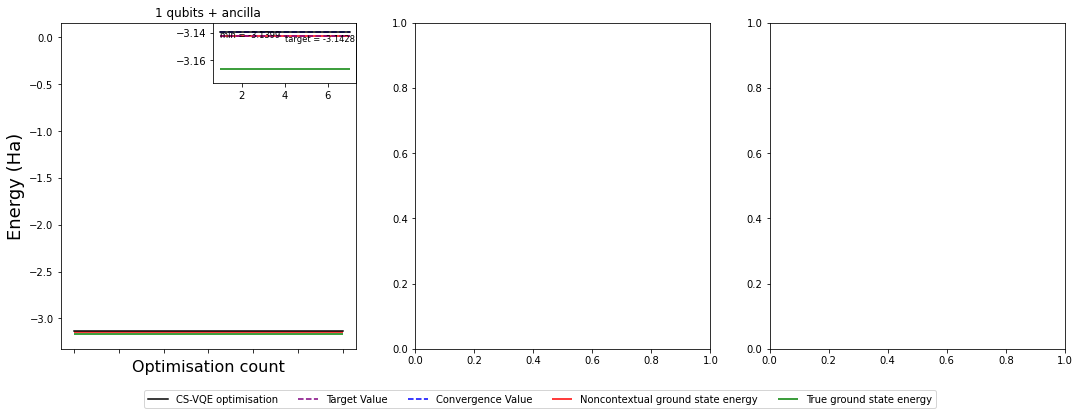

In [10]:
import utils.plotting_tools as plot

order = [6, 0, 1, 2, 3, 4, 5, 7]

cs_vqe_plot = plot.plot_cs_vqe_convergence(hamiltonian, terms_noncon, ucc, num_qubits, order, 3)

In [ ]:
for i in range(1, 5):
    print(circs.CS_VQE(ucc, i)[0])

In [ ]:
#take expectation value algebraically
from matplotlib import pyplot as plt
shots=5
true_gs=mol.true_gs()[0]

fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (21,12))
grid_pos = [(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]
#grid_pos.reverse()

X=list(range(1, shots+1))

for index, grid in enumerate(grid_pos):
    removed_index = list(range(0, index))
    removed_index.reverse()
    removed_generators = [list(G.keys())[i] for i in removed_index]
    Z_indices = [g.find('Z') for g in removed_generators]
    print('removed:', removed_generators)
    eig_ind = bit.unconstrain(initial_state, Z_indices)
    
    new_ham_noncon, new_ham_context = mol.move_generator(rem_gen=removed_generators, rot=True)
    new_ham_noncon_q = qonvert.dict_to_QubitOperator(new_ham_noncon)
    new_ham_context_q = qonvert.dict_to_QubitOperator(new_ham_context)
    
    random_amplitudes=[]
    for i in range(shots):  
        rand_vec = sorted(la.random_complex_vector(2**len(removed_index)), key=abs)
        rand_vec.reverse()
        random_amplitudes.append(rand_vec)
        
    Y_noncon=[]
    Y_context=[]
    Y_combined=[]
    Y_full=[]

    #A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
    #A = LinearQubitOperator(A_op, num_qubits)

    for amps in random_amplitudes:
        psi = sum([amps[i] * eig.eigenstate(A, index, num_qubits).construct() for i, index in enumerate(eig_ind)])
        
        expect_noncon = la.expectation(new_ham_noncon_q, psi, num_qubits)
        expect_context = la.expectation(new_ham_context_q, psi, num_qubits)
        
        #Y_full.append(expect_full)
        Y_noncon.append(expect_noncon)
        Y_context.append(expect_context)
        Y_combined.append(expect_noncon+expect_context)

        #print(p, expect_noncon + expect_context < gs_noncon_energy)
        #print((np.conjugate(psi)).dot(psi))
        #Verify +1-eigenstate
        #A_psi = A.matvec(psi)
        #print(psi_conj.dot(A_psi))
    
    axs[grid].plot(X, Y_noncon, color='orange')
    axs[grid].scatter(X, Y_context, color='blue', marker = 'x')
    axs[grid].plot(X, Y_context, color='blue', ls='--')
    axs[grid].scatter(X, Y_combined, color='black', marker = 'x')
    axs[grid].plot(X, Y_combined, color='black', ls='--')
    #plt.plot(range(shots), Y_combined, color='purple')
    axs[grid].hlines(gs_noncon_energy, 1, shots, color='r')
    axs[grid].hlines(true_gs, 1, shots, color='g')
    
    axs[grid].set_xticks(X)
    axs[grid].set_title("%i generators removed" % abs(index))
    if grid[0] == 1:
        axs[grid].set_xlabel('Sample Number',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #print('<H> w.r.t. simultaneous eigenstate:', expect)
    #print('Noncontextual approximation:', gs_noncon_energy)
    #print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 

In [ ]:
rotations = mol.rotations()
ucc_rot = c_tools.rotate_operator(rotations, ucc)

ucc_terms=[]
for p in ucc_rot.keys():
    p_list = list(p)
    p_list[3] = 'I'
    ucc_terms.append('I'+''.join(p_list))

In [ ]:
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

slsqp = SLSQP(maxiter=10000)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

P_index = eig.eigenstate(A, 16, num_qubits).P_index(q_pos=True)
t1 = abs(eig.eigenstate(A, 16, num_qubits).t_val())
t2 = abs(eig.eigenstate(A, 18, num_qubits).t_val())
anz=QuantumCircuit(num_qubits+1)

anz.x(1)
anz.x(4)
#anz.rx(Parameter('a'), 7)
#anz.rx(Parameter('b'), 6)
#anz.rx(Parameter('c'), 5)
#anz.rx(Parameter('d'), 4)
#anz.rx(Parameter('e'), 3)
#anz.rx(Parameter('f'), 2)
#anz.rx(Parameter('g'), 0)

anz = circ.circ_from_paulis(paulis=ucc_terms, circ=anz, trot_order=2)

#store parity in ancilla qubit (8) via CNOT cascade
anz = circ.cascade(P_index['Z1']+[8], circ=anz)

#move into +1-eigenstate
anz.cry(2*t1, num_qubits, 1)
anz.x(num_qubits)
anz.cry(-2*t1, num_qubits, 1)
anz.x(num_qubits)

#reverse CNOT cascade
anz = circ.cascade(P_index['Z1']+[8], circ=anz, reverse=True)

vqe = VQE(anz, optimizer=slsqp, callback=store_intermediate_result, quantum_instance=qi)#

h_add_anc={}
for p in ham.keys():
    p_add_q = 'I' + p
    h_add_anc[p_add_q] = ham[p]
vqe_input_ham = qonvert.dict_to_WeightedPauliOperator(h_add_anc)

vqe_run = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham)
vqe_result = vqe_run.optimal_value

print('VQE:', vqe_result, gs_noncon_energy, true_gs)

plt.plot(counts, values)

# Contextual Subspace VQE

In [ ]:
num_sim_q = 2
order = [6, 0, 1, 2, 3, 4, 5, 7]
q_pos_ord = [num_qubits-1-q for q in order]

sim_indices = order[0:num_sim_q]
sim_complement = order[num_sim_q:]
sim_qubits = q_pos_ord[0:num_sim_q]
# if ordering left to right
sim_qubits, sim_indices = zip(*sorted(list(zip(sim_qubits, sim_indices)), key=lambda x:x[1]))

ham_reduced = mol.reduced_hamiltonian(order, num_sim_q)
P_index = eig.eigenstate(A, 16, num_qubits).P_index(q_pos=True)
P_index_reduced = [q for q in P_index['Z1'] if q in sim_qubits]

sim_indices, sim_qubits, P_index

In [ ]:
qc.draw()

In [ ]:
lost_parity = 0
for i in sim_complement:
    lost_parity += int(initial_state[i])

In [ ]:
rotations = mol.rotations()
ucc_rot = c_tools.rotate_operator(rotations, ucc)

ucc_terms=[]
for p in ucc_rot.keys():
    p_list = list(p)
    p_list[6] = 'I'
    ucc_terms.append('I'+''.join(p_list))
    
ucc_terms == test

In [ ]:
ucc_terms_reduced = []
for p in ucc_rot.keys():
    blank_op = ['I' for i in range(num_sim_q)]
    for i, sim_i in enumerate(sim_indices):
        if sim_i != 6:
            blank_op[i] = p[sim_i]
    if set(blank_op) != {'I'}:
        ucc_terms_reduced.append('I'+''.join(blank_op))

ucc_terms_reduced == anz

In [ ]:
# Initialize a GPU backend
# Note that the cloud instance for tutorials does not have a GPU
# so this will raise an exception.
#try:
#    simulator_gpu = Aer.get_backend('aer_simulator')
#    simulator_gpu.set_options(device='GPU')
#except AerError as e:
#    print(e)

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

slsqp = SLSQP(maxiter=1000)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

order = [6, 0, 1, 2, 3, 4, 5, 7]
qc = cs_circ.cs_vqe_circuit(hamiltonian, terms_noncon, num_qubits, order).build_circuit(list(ucc.keys()), 4)

vqe = VQE(qc, optimizer=slsqp, callback=store_intermediate_result, quantum_instance=qi)#

h_add_anc={}
for p in ham_reduced.keys():
    p_add_q = 'I' + p
    h_add_anc[p_add_q] = ham_reduced[p]

vqe_input_ham = qonvert.dict_to_WeightedPauliOperator(h_add_anc)
ham_red_q = qonvert.dict_to_QubitOperator(h_add_anc)
gs_red = get_ground_state(get_sparse_operator(ham_red_q, num_sim_q+1).toarray())
target_energy = gs_red[0]

vqe_run = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham)

vqe_result = vqe_run.optimal_value

print('VQE:', vqe_result, target_energy)

plt.plot(counts, values)
plt.plot(range(len(counts)), [target_energy for i in range(len(counts))], ls='--')

In [ ]:
anz.draw()

In [ ]:
amp_list = [abs(a)**2 for a in list(gs_red[1])]
sig_amp_list = sorted([(str(index), a) for index, a in enumerate(amp_list) if a > 10**-7], key=lambda x:x[1])
sig_amp_list.reverse()

XY = list(zip(*sig_amp_list))
X = XY[0]
Y = XY[1]
Y_log = [np.log10(a) for a in Y]

from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=200)

plt.grid(zorder=0)
plt.bar(X, Y, zorder=2, label='Probability of observing basis state')
plt.bar(X, Y_log, zorder=3, label = 'log (base 10) of probability')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
list(zip(ucc_terms_reduced, list(ucc_rot.keys())))

In [ ]:
anz.save_state()

In [ ]:
type(vqe)

In [ ]:
list(A.keys())[0].find('X')